# Imports

In [2]:
#!pip install numpy-stl

In [3]:
#!pip install -U scikit-learn


In [4]:
#!pip install vtkplotlib

In [5]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [6]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [7]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [8]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [9]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [10]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[7.95865833 7.96070795 7.95867819 ... 2.50028471 7.17468883 2.5007074 ]
[13.06056126 13.06392478 13.06059385 ...  4.10309379 11.77402761
  4.10378745]
[1.         1.         1.         ... 0.99816994 0.99999999 0.99817189]
(5999,)


### Multinomial Sampling

In [11]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[1 0 0 ... 0 0 0]


In [12]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(83.96025, 7.5075808, 91.15137), (75.78312, -6.2811418, 96.142876), (87.79239, 7.8332825, 3.129579), (77.974686, -8.78582, -3.9493165), (89.292534, 6.7292814, 83.463715), (75.0252, -0.66553295, 3.8), (75.0, 8.78582, 89.50064), (75.0326, 3.2518802, 3.1779726), (77.66334, 7.8332825, 93.73002), (78.77187, 8.114116, 92.80864), (82.130325, -8.722893, 1.062925), (77.400055, 6.0434117, 3.6742187), (75.80706, 5.7970243, 96.59963), (81.10302, 8.114116, 91.770744), (75.0, 8.114116, 93.406044), (75.67042, -7.8332825, 93.99239), (75.0, -8.760632, 90.83147), (75.39972, 8.722893, 88.82714), (86.6957, 7.138877, 88.79528), (80.69563, -8.237194, 3.5015047), (77.27036, -8.447791, -2.1144972), (75.21095, -1.9813722, 3.7190232), (79.99763, 7.138877, 94.21927), (75.20018, -2.6241417, 81.54672), (75.622025, -3.2518802, 3.767401), (75.46927, 8.798424, -5.154244), (92.54333, -0.99710757, 3.8), (75.22565, -1.9813722, 3.7881742), (82.156, -0.33300498, -12.272642), (75.10053, -1.3272538, 3.7947316), (39.0, 8.04

# KNN

In [13]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[83.96025, 7.5075808, 91.15137], [75.78312, -6.2811418, 96.142876], [87.79239, 7.8332825, 3.129579], [77.974686, -8.78582, -3.9493165], [89.292534, 6.7292814, 83.463715], [75.0252, -0.66553295, 3.8], [75.0, 8.78582, 89.50064], [75.0326, 3.2518802, 3.1779726], [77.66334, 7.8332825, 93.73002], [78.77187, 8.114116, 92.80864], [82.130325, -8.722893, 1.062925], [77.400055, 6.0434117, 3.6742187], [75.80706, 5.7970243, 96.59963], [81.10302, 8.114116, 91.770744], [75.0, 8.114116, 93.406044], [75.67042, -7.8332825, 93.99239], [75.0, -8.760632, 90.83147], [75.39972, 8.722893, 88.82714], [86.6957, 7.138877, 88.79528], [80.69563, -8.237194, 3.5015047], [77.27036, -8.447791, -2.1144972], [75.21095, -1.9813722, 3.7190232], [79.99763, 7.138877, 94.21927], [75.20018, -2.6241417, 81.54672], [75.622025, -3.2518802, 3.767401], [75.46927, 8.798424, -5.154244], [92.54333, -0.99710757, 3.8], [75.22565, -1.9813722, 3.7881742], [82.156, -0.33300498, -12.272642], [75.10053, -1.3272538, 3.7947316], [39.0, 8.04

In [14]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [15]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  26


Number of nodes: 50
Number of edges: 811


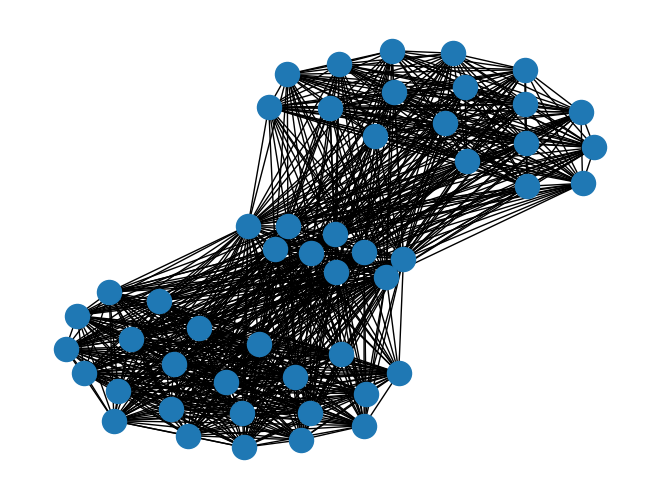

In [16]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [17]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [18]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\debor\AppData\Local\Temp\ipykernel_57132\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh

# Fonctions Loss

Récupération des points de l'espace de départ P

In [19]:
keys_input = list(graph._node.keys())
print(keys_input)
len(keys_input)  #return 5999

[(75.0252, -0.66553295, 3.8), (75.01418, -0.49935842, 16.7), (75.0, 0.0, 3.8), (75.00158, 0.16653232, 16.7), (75.0252, 0.66553295, 3.8), (75.03937, 0.8314692, 16.7), (75.10067, 1.3272538, 3.8), (75.12734, 1.4916434, 16.7), (75.22596, 1.9813722, 3.8), (75.26499, 2.1432736, 16.7), (75.40037, 2.6241417, 3.8), (75.45153, 2.7826276, 16.7), (75.62288, 3.2518802, 3.8), (75.68588, 3.4060426, 16.7), (75.892235, 3.8609922, 3.8), (75.96672, 4.0099483, 16.7), (76.20689, 4.4479885, 3.8), (76.29242, 4.590885, 16.7), (76.565025, 5.0095077, 3.8), (76.661125, 5.145526, 16.7), (76.96461, 5.5423326, 3.8), (77.07072, 5.670694, 16.7), (77.40334, 6.0434117, 3.8), (77.51886, 6.1633806, 16.7), (77.87872, 6.5098743, 3.8), (78.002975, 6.620764, 16.7), (78.388016, 6.9390492, 3.8), (78.5203, 7.0402236, 16.7), (78.92831, 7.328478, 3.8), (79.06786, 7.4193583, 16.7), (79.4965, 7.6759295, 3.8), (79.64253, 7.755995, 16.7), (80.08935, 7.9794145, 3.8), (80.24101, 8.048206, 16.7), (80.703445, 8.237194, 3.8), (80.859886, 

5999

Récupération des points de l'espace de départ Ps

In [20]:
keys_output = list(extended_graph)
print(keys_output)
len(keys_output)  #return: 50

[(83.96025, 7.5075808, 91.15137), (81.10302, 8.114116, 91.770744), (86.6957, 7.138877, 88.79528), (83.91283, 8.672658, 86.345825), (79.99763, 7.138877, 94.21927), (78.77187, 8.114116, 92.80864), (77.66334, 7.8332825, 93.73002), (75.39972, 8.722893, 88.82714), (75.0, 8.78582, 89.50064), (75.0, 8.114116, 93.406044), (89.292534, 6.7292814, 83.463715), (75.0, 7.138877, 95.14552), (75.80706, 5.7970243, 96.59963), (75.0, -1.9813722, 81.42596), (75.20018, -2.6241417, 81.54672), (75.78312, -6.2811418, 96.142876), (82.254074, -8.798424, 86.4704), (75.70939, -4.4479885, 82.17639), (78.20283, -7.9794145, 85.15517), (77.642975, -7.6759295, 84.837746), (75.67042, -7.8332825, 93.99239), (75.12578, -6.0434117, 83.60005), (75.0, -8.760632, 90.83147), (39.0, 8.048206, 86.44102), (39.0, -7.234973, 84.99049), (77.400055, 6.0434117, 3.6742187), (75.622025, -3.2518802, 3.767401), (87.79239, 7.8332825, 3.129579), (92.54333, -0.99710757, 3.8), (75.0326, 3.2518802, 3.1779726), (75.46927, 8.798424, -5.154244),

50

Création de la liste normes entre chaque point

In [21]:
import numpy as np

def compare_and_norm(keys_x, keys_y):
    normes_carre = []

    for x in keys_x:
        # Convertir les tuples en arrays NumPy pour le calcul de la norme
        keys_x_np = np.array(x)
        # Calculer la norme euclidienne au carré pour chaque point y dans keys_y
        distances_carre = [np.linalg.norm(keys_x_np - np.array(y))**2 for y in keys_y]
        # Ajouter la distance minimale au carré à la liste
        norme_carre = min(distances_carre)
        normes_carre.append(norme_carre)

    return normes_carre

def min_pour_y_list(keys_x, keys_y):
    # Calculer le min pour chaque point y dans keys_y
    return min(compare_and_norm(keys_x, keys_y))

def min_pour_x_list(keys_x, keys_y):
    # Calculer le min pour chaque point x dans keys_x
    return min(compare_and_norm(keys_x, keys_y))


In [22]:
compare_and_norm(keys_input, keys_output)

[0.0,
 166.43777013276213,
 0.44356911143836797,
 167.10291673568372,
 1.771736411969016,
 168.651232599791,
 3.9768949388514017,
 171.07387427712092,
 2.0384965894431986,
 174.35691138936454,
 0.916226459263271,
 178.4815895124857,
 0.7353469635280909,
 179.56510150718168,
 1.4969067770157949,
 175.86041060187654,
 3.196540695757122,
 173.00767768474543,
 1.782053230037718,
 171.0232102516611,
 0.45651581036521804,
 169.9183565739304,
 0.01583174758352257,
 169.6994851859572,
 0.4625315832274879,
 170.36784985772465,
 1.794054134777312,
 171.91957941840883,
 4.002768995583267,
 174.3458047840477,
 7.076008883088946,
 177.63263699000618,
 10.996222738409415,
 181.7612219765224,
 15.74088954049381,
 186.70801136162845,
 21.282869844910465,
 192.4444950968027,
 27.590449978024708,
 198.93796427190046,
 27.812603223661426,
 206.15122719063947,
 21.53256807103753,
 203.7877577108011,
 16.018159293864528,
 198.46984456655628,
 11.300850952348128,
 193.95623008883922,
 7.407754459568935,
 19

Chamfer distance

In [23]:
def d_P_Ps(P, Ps, p):
    """
    Parameters:
    - P : the input vertex set, a list of tuples
    - Ps : the sampled points, a list of tuples
    - p : their respective probabilities, a number

    Returns:
        d_P_Ps_result (float) : a float, the Chamfer distance
    """
    sum_part1 = sum(p * min_pour_y_list([x], Ps) for x in P)
    sum_part2 = sum(p * min_pour_x_list(Ps, [y]) for y in Ps)

    d_P_Ps_result = float(sum_part1 + sum_part2)

    return d_P_Ps_result

In [24]:
print("Chamfer distance d_P_Ps : ", d_P_Ps(keys_input, keys_output, 0.2))


Chamfer distance d_P_Ps :  92583.50289979592


## Probabilistic Surfaces Distance

In [28]:
def calculate_distance_between_surfaces(b, b_hat):
    """
    calculates the distance between probabilistic surfaces using their barycenters.
    
    Args:
    - b: Barycenters of the ground truth surface
    - b_hat: Barycenters of generated triangles with respective probabilities

    Returns:
    - Distance between probabilistic surfaces
    """
    distances = np.linalg.norm(b_hat[:, :3][:, np.newaxis, :] - b, axis=2)**2
    weighted_distances = b_hat[:, 3] * np.min(distances, axis=1)
    total_distance = np.sum(weighted_distances)
    return total_distance



In [30]:
# Exemple d'utilisation 
b_ground_truth = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
b_generated = np.array([[0.5, 1.5, 2.5, 0.8], [4.5, 5.5, 6.5, 0.6], [6.0, 8.0, 8.0, 0.7]])

distance_result = calculate_distance_between_surfaces(b_ground_truth, b_generated)

print("Distance entre surfaces probabilistes :", distance_result)

Distance entre surfaces probabilistes : 2.45


## Triangle Collision Loss

In [26]:
def triangle_collision_loss(generated_triangles, probabilities):
    """
    Calculate triangle collision loss to penalize triangles that penetrate each other.

    Parameters:
    - generated_triangles (numpy.ndarray): Array representing the generated triangles.
    - probabilities (numpy.ndarray): Array of probabilities for each generated triangle.

    Returns:
    - float: Triangle collision loss.
    """
    num_triangles = len(generated_triangles)

    # Create a 3D array to represent all combinations of triangle pairs
    triangle_pairs_i, triangle_pairs_j = np.meshgrid(range(num_triangles), range(num_triangles), indexing='ij')

    # Filter out pairs where i is not equal to j
    valid_pairs_mask = triangle_pairs_i != triangle_pairs_j

    # Extract triangles and probabilities for each pair
    triangles_i = generated_triangles[triangle_pairs_i[valid_pairs_mask]]
    triangles_j = generated_triangles[triangle_pairs_j[valid_pairs_mask]]
    probs_i = probabilities[triangle_pairs_i[valid_pairs_mask]]

    # Calculate the plane normals and distances for all triangles
    plane_normals = np.cross(triangles_i[:, 1] - triangles_i[:, 0], triangles_i[:, 2] - triangles_i[:, 0])

    # Calculate the edge vectors for all edges of triangles_j
    edge_vectors = triangles_j[:, [1, 2, 0], :] - triangles_j[:, [0, 1, 2], :]

    # Calculate the dot product of edge vectors and plane normals
    dot_products = np.sum(np.cross(edge_vectors, plane_normals[:, np.newaxis, :]) * triangles_i[:, 0], axis=2)

    # Count the number of faces penetrated for each triangle
    faces_penetrated = np.sum(dot_products < 0, axis=1)

    # Calculate the loss for each triangle
    loss_per_triangle = probs_i * faces_penetrated

    # Sum up the losses and normalize by the number of triangles
    triangle_losses = np.sum(loss_per_triangle) / num_triangles

    return triangle_losses

